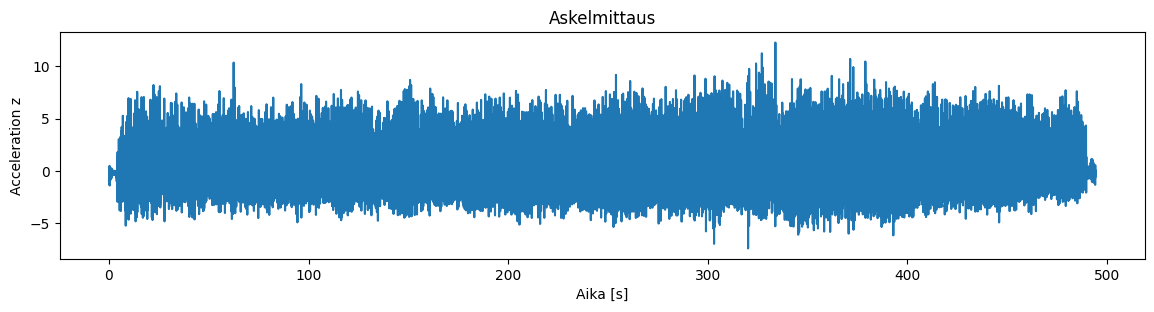

In [29]:

import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

# Tarkastellaan lineaarisen kiihtyvyyden x, y, z komponenttien dataa ja valitaan kuvaajien perusteella sopiva komponentti kävelyliikkeen havainnointiin


df = pd.read_csv('./My Experiment1/Linear Acceleration.csv')

plt.figure(figsize=(14,10))
plt.subplot(3,1,1)
#plt.plot(df['Time (s)'],df['Linear Acceleration x (m/s^2)'])
#plt.ylabel('Acceleration x')
#plt.subplot(3,1,2)
#plt.plot(df['Time (s)'],df['Linear Acceleration y (m/s^2)'])
#plt.ylabel('Acceleration y')
#plt.subplot(3,1,3)
plt.plot(df['Time (s)'],df['Linear Acceleration z (m/s^2)'])
plt.ylabel('Acceleration z')
plt.title('Askelmittaus')
plt.xlabel('Aika [s]')
plt.show()


Askelmäärä (suodatettu data): 938


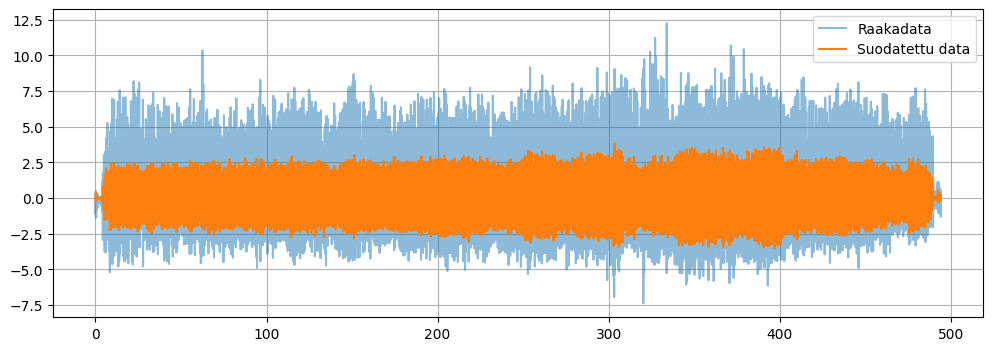

Askelmäärä (suodatettu data): 938


In [30]:
# Lasketaan askelten määrä suodatetusta datasta 

from scipy.signal import butter,filtfilt

def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)




def calculate_steps(df_acc):

    data = df['Linear Acceleration z (m/s^2)']
    t = df['Time (s)']

    T_tot = t.iloc[-1] - t.iloc[0]
    n = len(t)
    fs = n / T_tot

    # Kaistanpäästö kävelylle
    data_filt = butter_bandpass_filter(data, 0.5, 3.0, fs)

    # Askelmäärä nollakohdan ylityksistä
    steps = 0
    for i in range(n-1):
        if data_filt[i] * data_filt[i+1] < 0:
            steps += 0.5

    return int(round(steps))


# Data
data = df['Linear Acceleration z (m/s^2)']
t = df['Time (s)']

T_tot = t.iloc[-1] - t.iloc[0]
n = len(t)
fs = n / T_tot

# Kaistanpäästö kävelylle
data_filt = butter_bandpass_filter(data, 0.5, 3.0, fs)

# Askelmäärä nollakohdan ylityksistä
steps = 0
for i in range(n-1):
    if data_filt[i] * data_filt[i+1] < 0:
        steps += 0.5

print(f'Askelmäärä (suodatettu data): {int(round(steps))}')
T_tot = t.iloc[-1] - t.iloc[0]
n = len(t)
fs = n / T_tot

# Kaistanpäästö kävelylle
data_filt = butter_bandpass_filter(data, 0.5, 3.0, fs)

# Kuvaaja
plt.figure(figsize=(12,4))
plt.plot(t, data, label='Raakadata', alpha=0.5)
plt.plot(t, data_filt, label='Suodatettu data')
plt.legend()
plt.grid()
plt.show()

# Askelmäärä nollakohdan ylityksistä
steps = 0
for i in range(n-1):
    if data_filt[i] / data_filt[i+1] < 0:
        steps += 0.5

print(f'Askelmäärä (suodatettu data): {int(round(steps))}')

In [ ]:
# Tehdään funktio joka laskee askeleet ftt:llä 

def calculate_steps_ftt(df_acc):
    signal = df_acc['Linear Acceleration z (m/s^2)'] # valitaan z komponentti tarkeasteluun
    t = df_acc['Time (s)'] #Aika 
    N = len(signal) #Havaintojen määrä
    dt = np.max(t)/N #Näytteenottoväli (oletetaan vakioksi)

    #Fourier-analyysi 
    fourier = np.fft.fft(signal,N) #Fourier-muunnos
    psd = fourier*np.conj(fourier)/N #Tehospektri
    freq = np.fft.fftfreq(N,dt) #Taajuudet
    L = np.arange(1,int(N/2)) #Negatiivisten ja nollataajuuksien rajaus
    f_max = freq[L][psd[L] == np.max(psd[L])][0] #Kävelymittauksen kiihtyvyyyden z-komponentin tehospektrin suurinta tehoa vastaava taajuus. 
#Eli toisinsanoen askelluksen dominoiva taajuus.
    T = 1/f_max #Askeleeseen kuluva aika, eli jaksonaika (oletettaen, että dominoiva taajuus on askeltaajuus)
    steps =  f_max*np.max(t) #Askelmäärä
    return steps

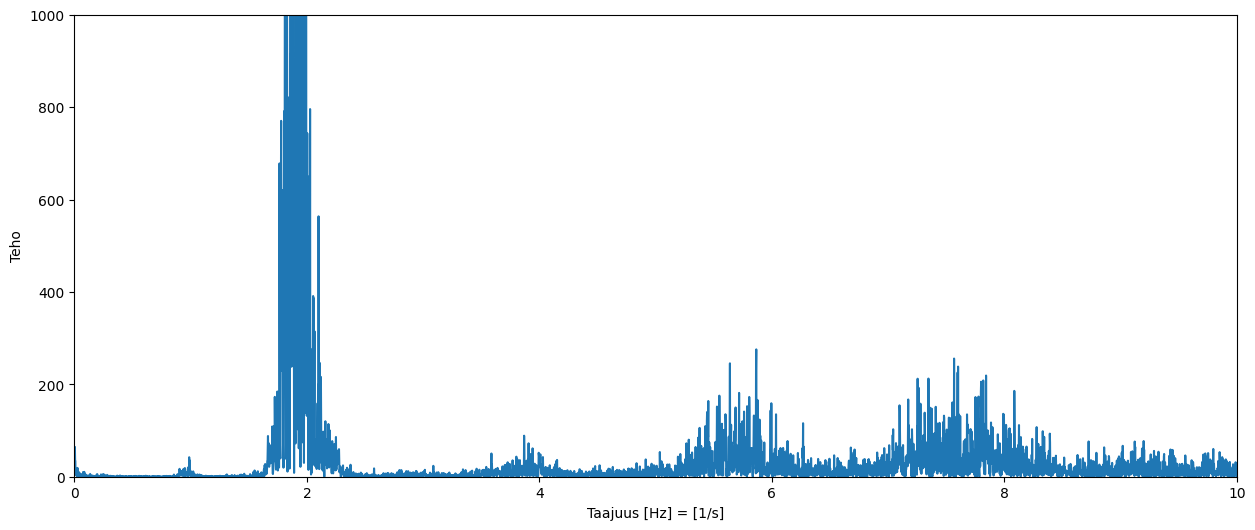

In [35]:

signal = df['Linear Acceleration z (m/s^2)'] # valitaan z komponentti tarkeasteluun
t = df['Time (s)'] #Aika 
N = len(signal) #Havaintojen määrä
dt = np.max(t)/N #Näytteenottoväli (oletetaan vakioksi)

#Fourier-analyysi 
fourier = np.fft.fft(signal,N) #Fourier-muunnos
psd = fourier*np.conj(fourier)/N #Tehospektri
freq = np.fft.fftfreq(N,dt) #Taajuudet
L = np.arange(1,int(N/2)) #Negatiivisten ja nollataajuuksien rajaus

plt.figure(figsize=(15,6))
plt.plot(freq[L],psd[L].real)
plt.xlabel('Taajuus [Hz] = [1/s]')
plt.ylabel('Teho')
plt.axis([0,10,0,1000])
plt.show()

In [26]:
 # Lasketaan askelten määrä askeltaajuuden perusteella
f_max = freq[L][psd[L] == np.max(psd[L])][0] #Kävelymittauksen kiihtyvyyyden z-komponentin tehospektrin suurinta tehoa vastaava taajuus. 
#Eli toisinsanoen askelluksen dominoiva taajuus.
T = 1/f_max #Askeleeseen kuluva aika, eli jaksonaika (oletettaen, että dominoiva taajuus on askeltaajuus)
steps =  f_max*np.max(t) #Askelmäärä

print(f'Dominoiva askeltaajuus on {f_max} Hz')
print(f'Tätä vastaava jaksonaika (askelaika) on {T} s' )
print('Askelmäärä tällöin ', np.round(steps) )

Dominoiva askeltaajuus on 1.9524801520154669 Hz
Tätä vastaava jaksonaika (askelaika) on 0.5121690988601038 s
Askelmäärä tällöin  965.0


In [10]:
# Ladataan GPS data 

import pandas as pd
import folium

df = pd.read_csv('./My Experiment1/Location.csv')

df.head()

df = df[df['Horizontal Accuracy (m)'] <= 10]
df = df.reset_index(drop =True)

#Määritellään "karttapohja", eli kartan keskipiste
lat1 = df['Latitude (°)'].mean() #Latitudin keskiarvo
long1 = df['Longitude (°)'].mean() #Longitudin keskiarvo

#luodaan kartta
my_map = folium.Map(location = [lat1,long1], zoom_start=15)

#Piirretään reitti kartalle:
folium.PolyLine(df[['Latitude (°)','Longitude (°)']], color = 'red', weight = 3).add_to(my_map)
my_map.save('Kartta_18.12.2025.html')

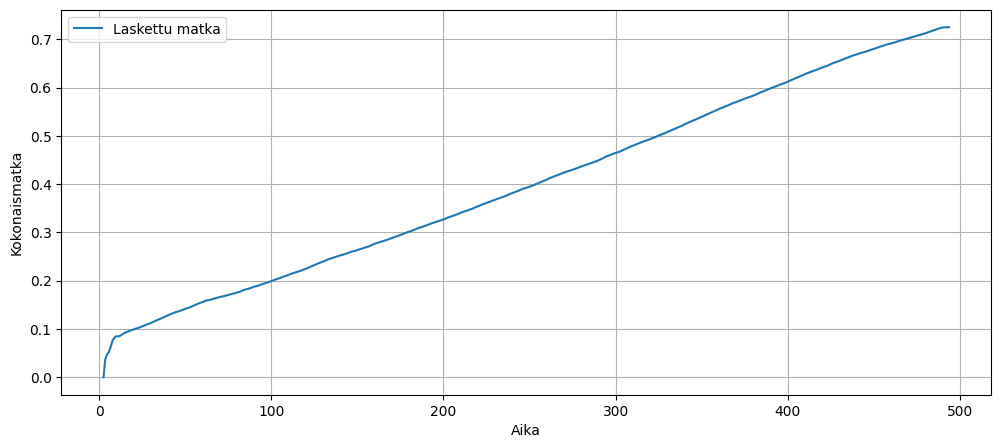

Kokonaismatka (m): 725.2365500542971


In [9]:
# Lasketaan kokonaismatka GPS- datasta
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("./My Experiment1/Location.csv")
#Lasketaan matka käyttäen Haversinen kaava
from math import radians, cos, sin, asin, sqrt
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    return c * r
#Lasketaan kuljettu matka
import numpy as np
df['Distance_calc'] = np.zeros(len(df))

#lasketaan väimatka havaintopisteiden välillä käyttäen For-luuppia
for i in range(len(df)-1):
    lon1 = df['Longitude (°)'][i]
    lon2 = df['Longitude (°)'][i+1]
    lat1 = df['Latitude (°)'][i]
    lat2 = df['Latitude (°)'][i+1]
    df.loc[i+1,'Distance_calc'] = haversine(lon1, lat1, lon2, lat2)

#Lasketaan kokonaismatka mittapisteiden välisestä matkasta
df['total_distance'] = df['Distance_calc'].cumsum()
plt.figure(figsize=(12,5))
plt.plot(df['Time (s)'],df['total_distance'])
#plt.plot(df['Time (s)'],df['Distance (km)'])
plt.ylabel('Kokonaismatka')
plt.xlabel('Aika')
plt.legend(['Laskettu matka','Matka datasta'])
plt.grid()
plt.show()
df.head()
print("Kokonaismatka (m):", df['total_distance'].iloc[-1] * 1000)